In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.optimize as sco

plt.style.use('fivethirtyeight')
np.random.seed(777)

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
directory = '../dataset/'
stocks = ['AMD.csv', 'FB.csv', 'TSLA.csv', 'TWTR.csv', 'MONDY.csv']
stocks = [directory + s for s in stocks]
stocks

['../dataset/AMD.csv',
 '../dataset/FB.csv',
 '../dataset/TSLA.csv',
 '../dataset/TWTR.csv',
 '../dataset/MONDY.csv']

In [3]:
dfs = [pd.read_csv(s)[['Date', 'Close']] for s in stocks]
for df in dfs:
    df.Date = pd.to_datetime(df.Date)
dfs[0].head()

,Date,Close
0,2018-05-23,13.10
1,2018-05-24,13.41
2,2018-05-25,13.54
3,2018-05-29,13.36
4,2018-05-30,13.82


Let’s transform the data a little bit to make it easier to work with.

In [4]:
from functools import reduce
data = reduce(lambda left,right: pd.merge(left,right,on='Date'), dfs).set_index('Date')
data.columns = ['AMD','FB','TSLA','TWTR','MONDY']
data.head()

,AMD,FB,TSLA,TWTR,MONDY
Date,,,,,
2018-07-13,16.270000,207.320007,63.773998,44.490002,56.889999
2018-07-16,16.580000,207.229996,62.020000,44.259998,56.639999
2018-07-17,16.870001,209.990005,64.538002,44.709999,57.730000
2018-07-18,16.850000,209.360001,64.769997,43.340000,57.810001
2018-07-19,16.709999,208.089996,64.045998,43.439999,52.380001


Let’s first look at how the price of each stock has evolved within the given time frame.

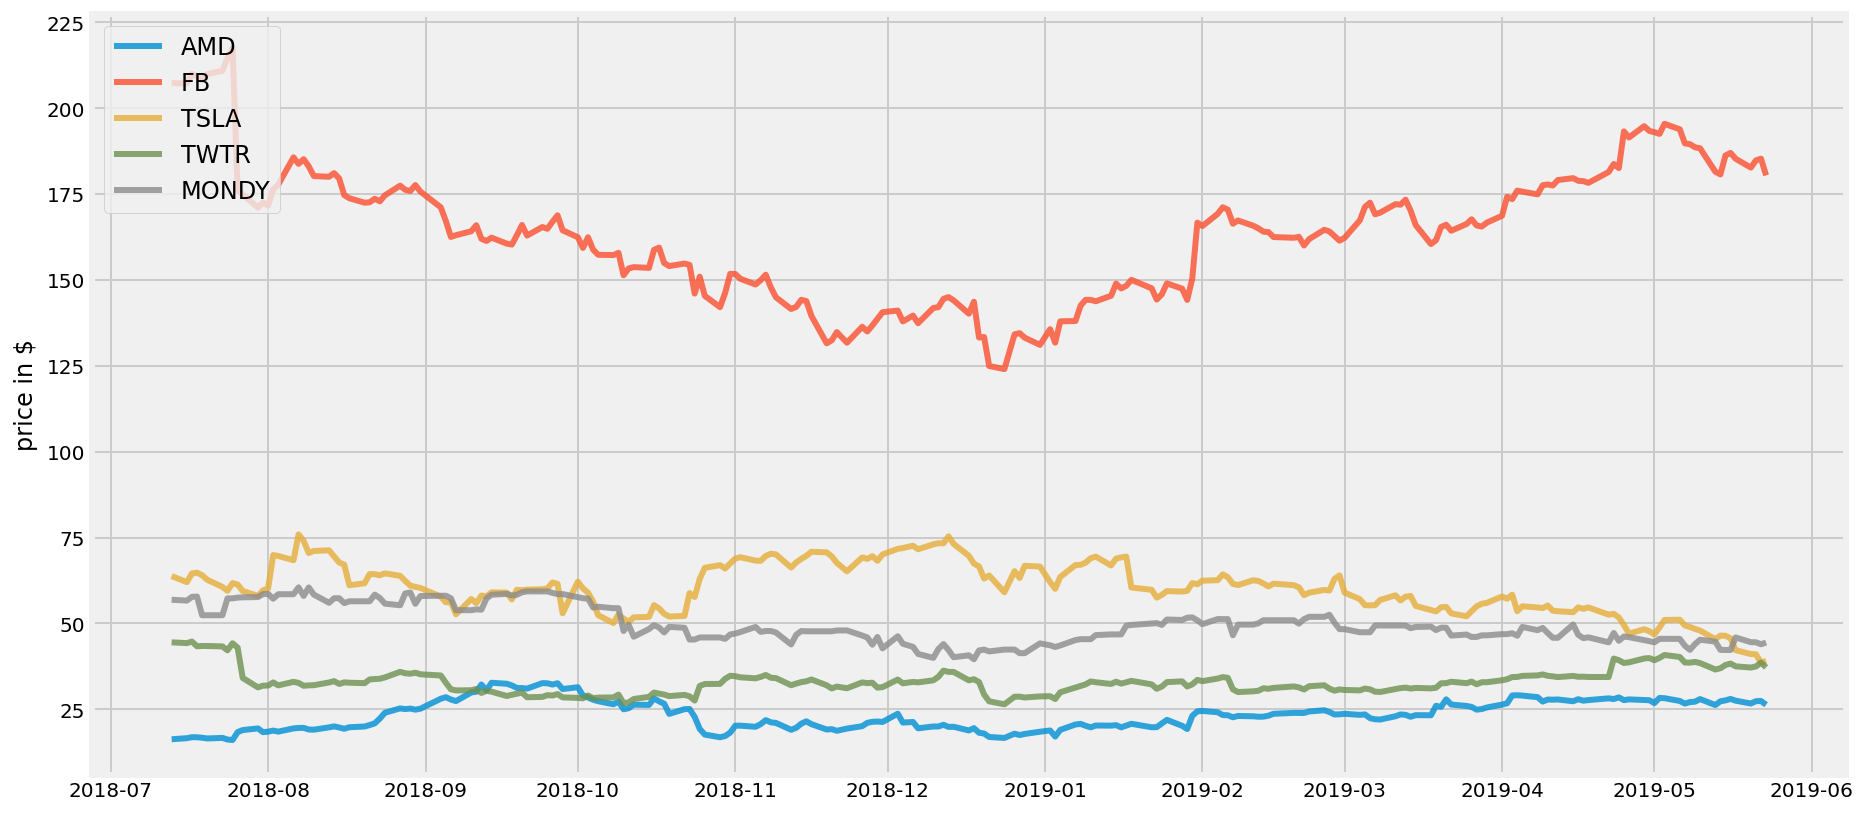

In [5]:
plt.figure(figsize=(14, 7))
for c in data.columns.values:
    plt.plot(data.index, data[c], lw=3, alpha=0.8,label=c)
plt.legend(loc='upper left', fontsize=12)
plt.ylabel('price in $')
plt.show()

Another way to plot this is plotting daily returns (percent change compared to the day before). By plotting daily returns instead of actual prices, we can see the stocks’ volatility.

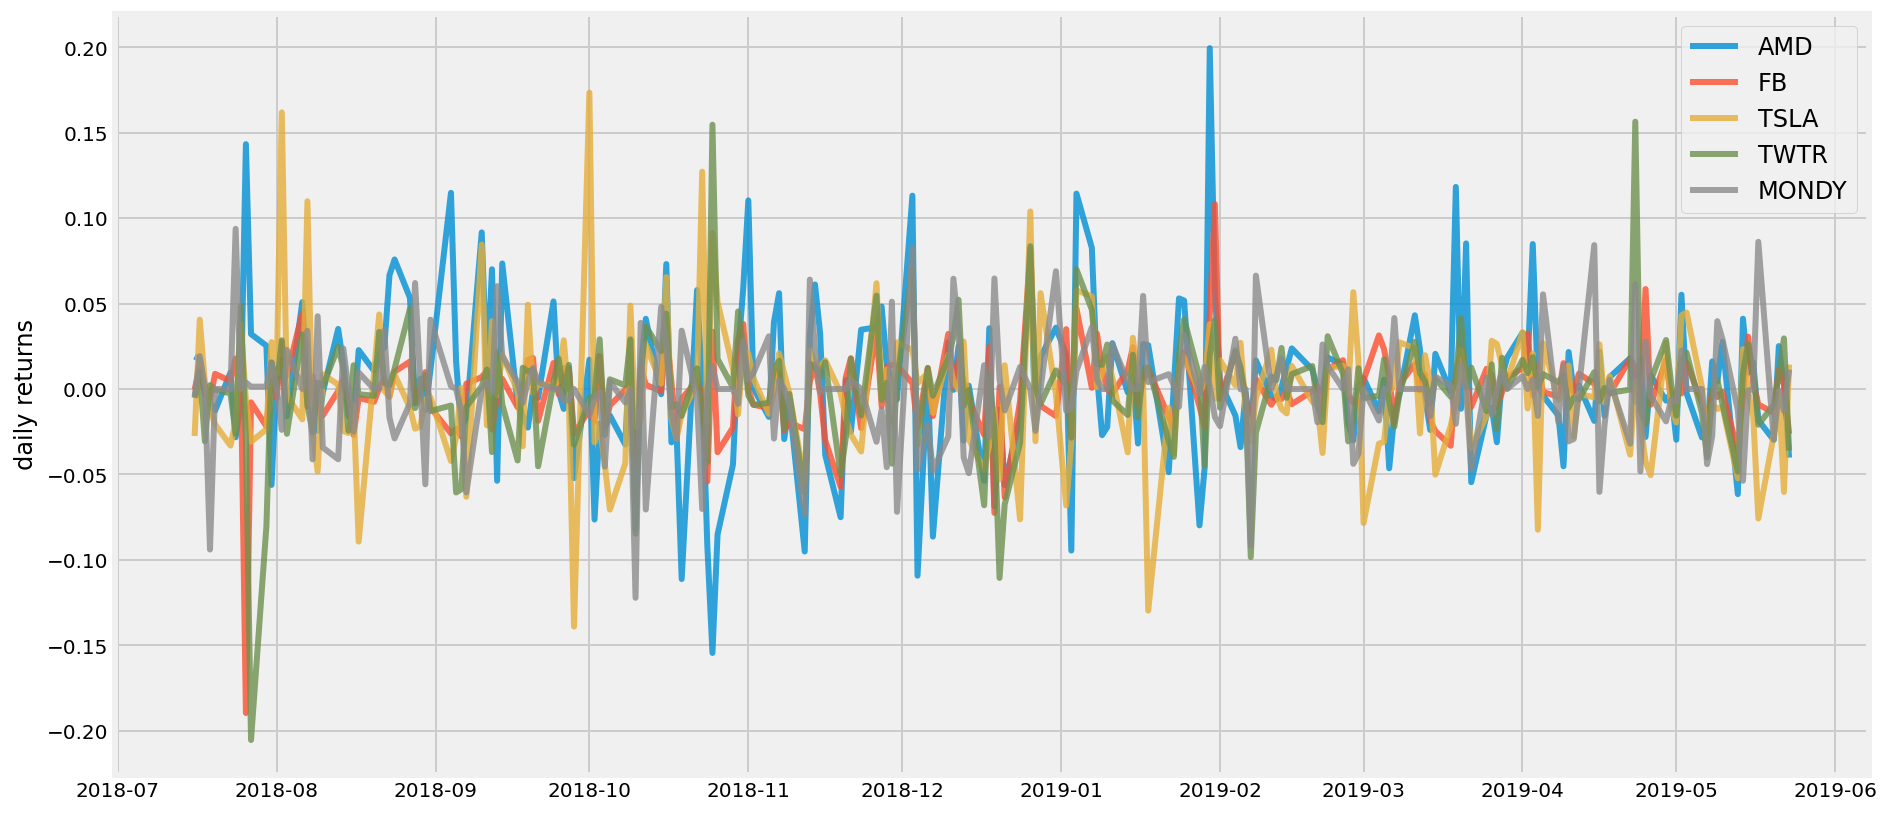

In [6]:
returns = data.pct_change()

plt.figure(figsize=(14, 7))
for c in returns.columns.values:
    plt.plot(returns.index, returns[c], lw=3, alpha=0.8,label=c)
plt.legend(loc='upper right', fontsize=12)
plt.ylabel('daily returns')
plt.show()

## Random Portfolios Generation

We have 5 stocks in our portfolio. One decision we have to make is how we should allocate our budget to each of stock in our portfolio. If our total budget is 1, then we can decide the weights for each stock, so that the sum of weights will be 1. And the value for weights will be the portion of budget we allocate to a specific stock. For example, if weight is 0.5 for Amazon, it means that we allocate 50% of our budget to Amazon.

Let’s define some functions to simulate random weights to each stock in the portfolio, then calculate the portfolio’s overall annualised returns and annualised volatility.

- `portfolio_annualised_performance` function will calculate the returns and volatility, and to make it as an annualised calculation I take into account 252 as the number of trading days in one year. - - --

- `random_portfolios` function will generate portfolios with random weights assigned to each stock, and by giving num_portfolios argument, you can decide how many random portfolios you want to generate.

In [7]:
def portfolio_annualised_performance(weights, mean_returns, cov_matrix):
    returns = np.sum(mean_returns*weights ) *252
    std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(252)
    return std, returns
  
def random_portfolios(num_portfolios, mean_returns, cov_matrix, risk_free_rate):
    results = np.zeros((3,num_portfolios))
    weights_record = []
    for i in range(num_portfolios):
        weights = np.random.random(5)
        weights /= np.sum(weights)
        weights_record.append(weights)
        portfolio_std_dev, portfolio_return = portfolio_annualised_performance(weights, mean_returns, cov_matrix)
        results[0,i] = portfolio_std_dev
        results[1,i] = portfolio_return
        results[2,i] = (portfolio_return - risk_free_rate) / portfolio_std_dev
    return results, weights_record

### Portfolio standard deviation

The calculation for portfolio’s volatility in `portfolio_annualised_performance` function is derived from the standard formula for portfolio standard deviation:

$$\sigma_p = \sqrt{w_1^2\sigma_1^2+w_2^2\sigma_2^2+2w_1w_2 \sigma_{1,2}}$$

This formula can be [simplified](https://medium.com/python-data/assessing-risks-and-return-with-probabilities-of-events-with-python-c564d9be4db4) if we make use of matrix notation.


$$\begin{align}
  \sigma_p^2 &= \begin{bmatrix} w_{1} & w_{2} \end{bmatrix}\begin{bmatrix} \sigma_{1}^2 & \sigma_{1,2} \\ \sigma_{2,1} & \sigma_{2}^2 \end{bmatrix}\begin{bmatrix} w_{1} \\ w_{2} \end{bmatrix} \\
  &= \begin{bmatrix}w_1\sigma_1^2+w_2\sigma_{2,1} &w_1\sigma_{1,2}+w_2\sigma_2^2\end{bmatrix}\begin{bmatrix} w_{1} \\ w_{2} \end{bmatrix} \\
  &= w_1^2\sigma_1^2+w_1w_2 \sigma_{2,1}+w_1w_2 \sigma_{1,2}+w_2^2\sigma_2^2 \\
  &= w_1^2\sigma_1^2+w_2^2\sigma_2^2+2w_1w_2 \sigma_{1,2} 
\end{align}$$

With the above matrix calculation, we get the part inside the square root in the original formula. Now, all we need to do is put them inside the square root. Same as the annualised return, I took into account of 252 trading days (in this case, the square root of 252) to calculate the annualised standard deviation of a portfolio.

### Sharpe ratio

In order to understand the Sharpe ratio, it is essential to understand the broader concept of risk-adjusted return. Risk-adjusted return refines an investment’s return by measuring how much risk is involved in producing that return, which is generally expressed as a number or rating. There could be a number of different methods of expressing risk-adjusted return, and the Sharpe ratio is one of them.

The ratio describes how much excess return you are receiving for the extra volatility that you endure for holding a riskier asset. The Sharpe ratio can be expressed as:

$$s=\frac{\bar{r}_p-r_t}{\sigma_p}$$

where $\hat{r}_p$ is the expected portfolio return, $r_t$ is the risk free rate, and $\sigma_p$ is the portfolio standard deviation. 

There are some criticisms on how the Sharpe ratio uses the standard deviation of returns as a denominator, which assumes the normal distribution of the returns. However, more often thans not, the returns on financial assets tend to deviate from a normal distribution and may make interpretations of the Sharpe ratio misleading. It is for this reason that there are other methods which adjust or modify the original Sharpe ratio. But it is a more advanced topic, and I will stick to the traditional Sharpe ratio for this post.

Let’s get the needed argument values for our functions. You can easily get daily returns by calling `pct_change` on the data frame with the price data. And the mean daily returns, the covariance matrix of returns are needed to calculate portfolio returns and volatility. We will generate 25,000 random portfolios. Finally, the risk-free rate has been taken from U.S. Department of The Treasury. The rate of 1.78% is the 52week treasury bill rates at the start of 2018. 

In [8]:
mean_daily_returns = returns.mean()
cov_matrix = returns.cov()
num_portfolios = 25000
risk_free_rate = 0.0178

Let me briefly explain what below function is doing. First, it generates random portfolio and gets the results (portfolio returns, portfolio volatility, portfolio Sharpe ratio) and weights for the corresponding result. Then by locating the one with the highest Sharpe ratio portfolio, it displays maximum Sharpe ratio portfolio as red star sign. And does similar steps for minimum volatility portfolio, and displays it as a green star on the plot. All the randomly generated portfolios will be also plotted with colour map applied to them based on the Sharpe ratio. Bluer, higher the Sharpe ratio.

And for these two optimal portfolios, it will also show how it allocates the budget within the portfolio.

In [9]:
def display_simulated_ef_with_random(mean_returns, cov_matrix, num_portfolios, risk_free_rate):
    results, weights = random_portfolios(num_portfolios,mean_returns, cov_matrix, risk_free_rate)
    
    max_sharpe_idx = np.argmax(results[2])
    sdp, rp = results[0,max_sharpe_idx], results[1,max_sharpe_idx]
    max_sharpe_allocation = pd.DataFrame(weights[max_sharpe_idx],index=data.columns,columns=['allocation'])
    max_sharpe_allocation.allocation = [round(i*100,2)for i in max_sharpe_allocation.allocation]
    max_sharpe_allocation = max_sharpe_allocation.T
    
    min_vol_idx = np.argmin(results[0])
    sdp_min, rp_min = results[0,min_vol_idx], results[1,min_vol_idx]
    min_vol_allocation = pd.DataFrame(weights[min_vol_idx],index=data.columns,columns=['allocation'])
    min_vol_allocation.allocation = [round(i*100,2)for i in min_vol_allocation.allocation]
    min_vol_allocation = min_vol_allocation.T
    
    print ("-"*50)
    print ("Maximum Sharpe Ratio Portfolio Allocation\n")
    print ("Annualised Return:", round(rp,2))
    print ("Annualised Volatility:", round(sdp,2))
    print ("\n")
    print (max_sharpe_allocation)
    print ("-"*50)
    print ("Minimum Volatility Portfolio Allocation\n")
    print ("Annualised Return:", round(rp_min,2))
    print ("Annualised Volatility:", round(sdp_min,2))
    print ("\n")
    print (min_vol_allocation)
    
    plt.figure(figsize=(10, 7))
    plt.scatter(results[0,:],results[1,:],c=results[2,:],cmap='YlGnBu', marker='o', s=10, alpha=0.3)
    plt.colorbar()
    plt.scatter(sdp,rp,marker='*',color='r',s=500, label='Maximum Sharpe ratio')
    plt.scatter(sdp_min,rp_min,marker='*',color='g',s=500, label='Minimum volatility')
    plt.title('Simulated Portfolio Optimization based on Efficient Frontier')
    plt.xlabel('annualised volatility')
    plt.ylabel('annualised returns')
    plt.legend(labelspacing=0.8)

--------------------------------------------------
Maximum Sharpe Ratio Portfolio Allocation

Annualised Return: 0.6
Annualised Volatility: 0.58


              AMD   FB  TSLA  TWTR  MONDY
allocation  78.44  0.3  2.82  3.01  15.43
--------------------------------------------------
Minimum Volatility Portfolio Allocation

Annualised Return: -0.08
Annualised Volatility: 0.29


             AMD     FB   TSLA  TWTR  MONDY
allocation  7.84  47.66  14.11  1.36  29.03


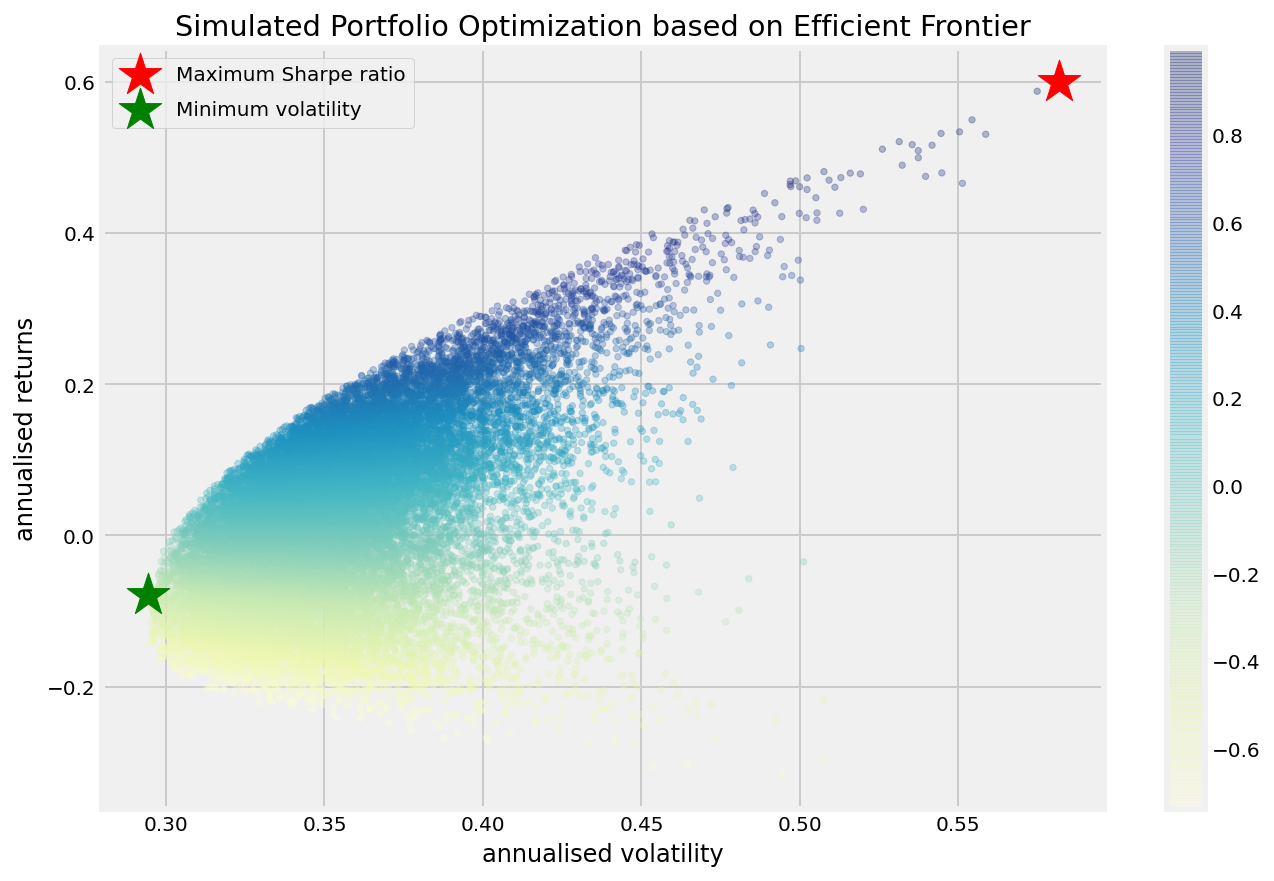

In [10]:
display_simulated_ef_with_random(mean_daily_returns, cov_matrix, num_portfolios, risk_free_rate)

For minimum risk portfolio, we can see that almost half of our budget is allocated to FB. If you take another look at the daily return plot from earlier, you can see that FB is the least volatile stock, so allocating a large percentage to it for minimum risk portfolio makes intuitive sense.

If we are willing to take higher risk for higher return, one that gives us the best risk-adjusted return is the one with maximum Sharpe ratio. In this scenario, we are allocating a significant portion to AMD, which are quite volatile stocks from the previous plot of daily returns.

## Efficient Frontier

From the plot of the randomly simulated portfolios, we can see it forms a shape of an arch line on the top of clustered blue dots. This line is called efficient frontier. Why is it efficient? Because points along the line will give you the lowest risk for a given target return. All the other dots right to the line will give you higher risk with same returns. If the expected returns are the same, why would you take an extra risk when there’s an option with lower risk?

The way we found the two kinds of optimal portfolio above was by simulating many possible random choices and pick the best ones (either minimum risk or maximum risk-adjusted return). We can also implement this by using Scipy’s optimize function.

Scipy’s optimize function is doing the optimization task when given what to optimize, and what are constraints and bounds.

Below functions are to get the maximum Sharpe ratio portfolio. In Scipy’s optimize function, there’s no ‘maximize’, so as an objective function you need to pass something that should be minimized. That is why the first “neg_sharpe_ratio” is computing the negative Sharpe ratio. Now we can use this as our objective function to minimize. In “max_sharpe_ratio” function, you first define arguments (this should not include the variables you would like to change for optimisation, in this case, “weights”).

In [11]:
constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})

The above constraint is saying that sum of x should be equal to 1. You can think of the ‘fun’ part construction as ‘1’ on the right side of equal sign has been moved to the left side of the equal sign.

`np.sum(x) == 1 has become np.sum(x)-1`

And what does this mean? It simply means that the sum of all the weights should be equal to 1. You cannot allocate more than 100% of your budget in total.

“bounds” is giving another limit to assign random weights, by saying any weight should be inclusively between 0 and 1. You cannot give minus budget allocation to a stock or more than 100% allocation to a stock.

In [12]:
def neg_sharpe_ratio(weights, mean_returns, cov_matrix, risk_free_rate):
    p_var, p_ret = portfolio_annualised_performance(weights, mean_returns, cov_matrix)
    return -(p_ret - risk_free_rate) / p_var

def max_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix, risk_free_rate)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = (0.0,1.0)
    bounds = tuple(bound for asset in range(num_assets))
    result = sco.minimize(neg_sharpe_ratio, num_assets*[1./num_assets,], args=args,
                        method='SLSQP', bounds=bounds, constraints=constraints)
    return result

We can also define an optimising function for calculating minimum volatility portfolio. This time we really do minimise objective function. What do we want to minimise? We want to minimise volatility by trying different weights. “constraints” and “bounds” are same as the above.

In [13]:
def portfolio_volatility(weights, mean_returns, cov_matrix):
    return portfolio_annualised_performance(weights, mean_returns, cov_matrix)[0]

def min_variance(mean_returns, cov_matrix):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = (0.0,1.0)
    bounds = tuple(bound for asset in range(num_assets))

    result = sco.minimize(portfolio_volatility, num_assets*[1./num_assets,], args=args,
                        method='SLSQP', bounds=bounds, constraints=constraints)

    return result

As I already mentioned above we can also draw a line which depicts where the efficient portfolios for a given risk rate should be. This is called “efficient frontier”. Below I define other functions to compute efficient frontier. The first function “efficient_return” is calculating the most efficient portfolio for a given target return, and the second function “efficient_frontier” will take a range of target returns and compute efficient portfolio for each return level.

In [14]:
def efficient_return(mean_returns, cov_matrix, target):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix)

    def portfolio_return(weights):
        return portfolio_annualised_performance(weights, mean_returns, cov_matrix)[1]

    constraints = ({'type': 'eq', 'fun': lambda x: portfolio_return(x) - target},
                   {'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0,1) for asset in range(num_assets))
    result = sco.minimize(portfolio_volatility, num_assets*[1./num_assets,], args=args, method='SLSQP', bounds=bounds, constraints=constraints)
    return result


def efficient_frontier(mean_returns, cov_matrix, returns_range):
    efficients = []
    for ret in returns_range:
        efficients.append(efficient_return(mean_returns, cov_matrix, ret))
    return efficients

Let’s try to plot the portfolio choices with maximum Sharpe ratio and minimum volatility also with all the randomly generated portfolios. But this time, we are not picking the optimal ones from the randomly generated portfolios, but we are actually calculating by using Scipy’s ‘minimize’ function. And the below function will also plot the efficient frontier line.

In [15]:
def display_calculated_ef_with_random(mean_returns, cov_matrix, num_portfolios, risk_free_rate):
    results, _ = random_portfolios(num_portfolios,mean_returns, cov_matrix, risk_free_rate)
    
    max_sharpe = max_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate)
    sdp, rp = portfolio_annualised_performance(max_sharpe['x'], mean_returns, cov_matrix)
    max_sharpe_allocation = pd.DataFrame(max_sharpe.x,index=data.columns,columns=['allocation'])
    max_sharpe_allocation.allocation = [round(i*100,2)for i in max_sharpe_allocation.allocation]
    max_sharpe_allocation = max_sharpe_allocation.T

    min_vol = min_variance(mean_returns, cov_matrix)
    sdp_min, rp_min = portfolio_annualised_performance(min_vol['x'], mean_returns, cov_matrix)
    min_vol_allocation = pd.DataFrame(min_vol.x,index=data.columns,columns=['allocation'])
    min_vol_allocation.allocation = [round(i*100,2)for i in min_vol_allocation.allocation]
    min_vol_allocation = min_vol_allocation.T
    
    print ("-"*50)
    print ("Maximum Sharpe Ratio Portfolio Allocation\n")
    print ("Annualised Return:", round(rp,2))
    print ("Annualised Volatility:", round(sdp,2))
    print ("\n")
    print (max_sharpe_allocation)
    print ("-"*50)
    print ("Minimum Volatility Portfolio Allocation\n")
    print ("Annualised Return:", round(rp_min,2))
    print ("Annualised Volatility:", round(sdp_min,2))
    print ("\n")
    print (min_vol_allocation)
    
    plt.figure(figsize=(10, 7))
    plt.scatter(results[0,:],results[1,:],c=results[2,:],cmap='YlGnBu', marker='o', s=10, alpha=0.3)
    plt.colorbar()
    plt.scatter(sdp,rp,marker='*',color='r',s=500, label='Maximum Sharpe ratio')
    plt.scatter(sdp_min,rp_min,marker='*',color='g',s=500, label='Minimum volatility')

    target = np.linspace(rp_min, 0.32, 50)
    efficient_portfolios = efficient_frontier(mean_returns, cov_matrix, target)
    plt.plot([p['fun'] for p in efficient_portfolios], target, linestyle='-.', color='black', label='efficient frontier')
    plt.title('Calculated Portfolio Optimization based on Efficient Frontier')
    plt.xlabel('annualised volatility')
    plt.ylabel('annualised returns')
    plt.legend(labelspacing=0.8)
    plt.savefig('portfolio-optimization.png')

--------------------------------------------------
Maximum Sharpe Ratio Portfolio Allocation

Annualised Return: 0.81
Annualised Volatility: 0.71


              AMD   FB  TSLA  TWTR  MONDY
allocation  100.0  0.0   0.0   0.0    0.0
--------------------------------------------------
Minimum Volatility Portfolio Allocation

Annualised Return: -0.11
Annualised Volatility: 0.29


            AMD     FB   TSLA  TWTR  MONDY
allocation  5.6  46.78  16.17   0.0  31.45


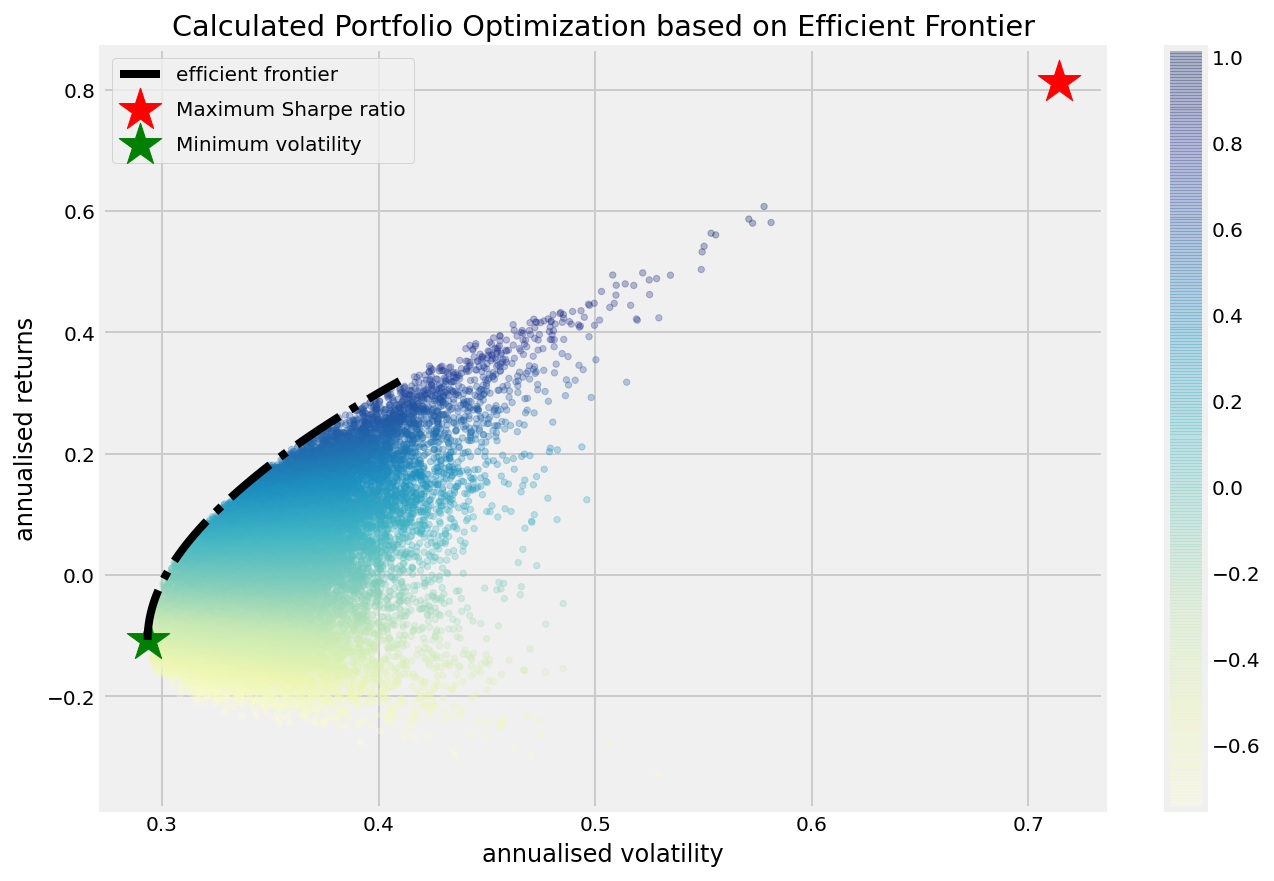

In [16]:
display_calculated_ef_with_random(mean_daily_returns, cov_matrix, num_portfolios, risk_free_rate)

We have almost the same result as what we have simulated by picking from the randomly generated portfolios. The slight difference is that the Scipy’s “optimize” function has allocated all budget at AMD on maximum Sharpe ratio portfolio, while one we chose from the randomly generated samples has 78.44% of allocation for AMD. There are some differences in the decimal places but more or less same.

Instead of plotting every randomly generated portfolio, we can plot each individual stocks on the plot with the corresponding values of each stock’s annual return and annual risk. This way we can see and compare how diversification is lowering the risk by optimising the allocation.

In [17]:
def display_ef_with_selected(mean_returns, cov_matrix, risk_free_rate):
    max_sharpe = max_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate)
    sdp, rp = portfolio_annualised_performance(max_sharpe['x'], mean_returns, cov_matrix)
    max_sharpe_allocation = pd.DataFrame(max_sharpe.x,index=data.columns,columns=['allocation'])
    max_sharpe_allocation.allocation = [round(i*100,2)for i in max_sharpe_allocation.allocation]
    max_sharpe_allocation = max_sharpe_allocation.T

    min_vol = min_variance(mean_returns, cov_matrix)
    sdp_min, rp_min = portfolio_annualised_performance(min_vol['x'], mean_returns, cov_matrix)
    min_vol_allocation = pd.DataFrame(min_vol.x,index=data.columns,columns=['allocation'])
    min_vol_allocation.allocation = [round(i*100,2)for i in min_vol_allocation.allocation]
    min_vol_allocation = min_vol_allocation.T
    
    an_vol = np.std(returns) * np.sqrt(252)
    an_rt = mean_returns * 252
    
    print ("-"*50)
    print ("Maximum Sharpe Ratio Portfolio Allocation\n")
    print ("Annualised Return:", round(rp,2))
    print ("Annualised Volatility:", round(sdp,2))
    print ("\n")
    print (max_sharpe_allocation)
    print ("-"*50)
    print ("Minimum Volatility Portfolio Allocation\n")
    print ("Annualised Return:", round(rp_min,2))
    print ("Annualised Volatility:", round(sdp_min,2))
    print ("\n")
    print (min_vol_allocation)
    print ("-"*50)
    print ("Individual Stock Returns and Volatility\n")
    for i, txt in enumerate(data.columns):
        print (txt,":","annuaised return",round(an_rt[i],2),", annualised volatility:",round(an_vol[i],2))
    print ("-"*50)
    
    fig, ax = plt.subplots(figsize=(10, 7))
    ax.scatter(an_vol,an_rt,marker='o',s=200)

    for i, txt in enumerate(data.columns):
        ax.annotate(txt, (an_vol[i],an_rt[i]), xytext=(10,0), textcoords='offset points')
    ax.scatter(sdp,rp,marker='*',color='r',s=500, label='Maximum Sharpe ratio')
    ax.scatter(sdp_min,rp_min,marker='*',color='g',s=500, label='Minimum volatility')

    target = np.linspace(rp_min, 0.34, 50)
    efficient_portfolios = efficient_frontier(mean_returns, cov_matrix, target)
    ax.plot([p['fun'] for p in efficient_portfolios], target, linestyle='-.', color='black', label='efficient frontier')
    ax.set_title('Portfolio Optimization with Individual Stocks')
    ax.set_xlabel('annualised volatility')
    ax.set_ylabel('annualised returns')
    ax.legend(labelspacing=0.8)

--------------------------------------------------
Maximum Sharpe Ratio Portfolio Allocation

Annualised Return: 0.81
Annualised Volatility: 0.71


              AMD   FB  TSLA  TWTR  MONDY
allocation  100.0  0.0   0.0   0.0    0.0
--------------------------------------------------
Minimum Volatility Portfolio Allocation

Annualised Return: -0.11
Annualised Volatility: 0.29


            AMD     FB   TSLA  TWTR  MONDY
allocation  5.6  46.78  16.17   0.0  31.45
--------------------------------------------------
Individual Stock Returns and Volatility

AMD : annuaised return 0.81 , annualised volatility: 0.71
FB : annuaised return -0.08 , annualised volatility: 0.39
TSLA : annuaised return -0.38 , annualised volatility: 0.61
TWTR : annuaised return -0.06 , annualised volatility: 0.54
MONDY : annuaised return -0.16 , annualised volatility: 0.5
--------------------------------------------------


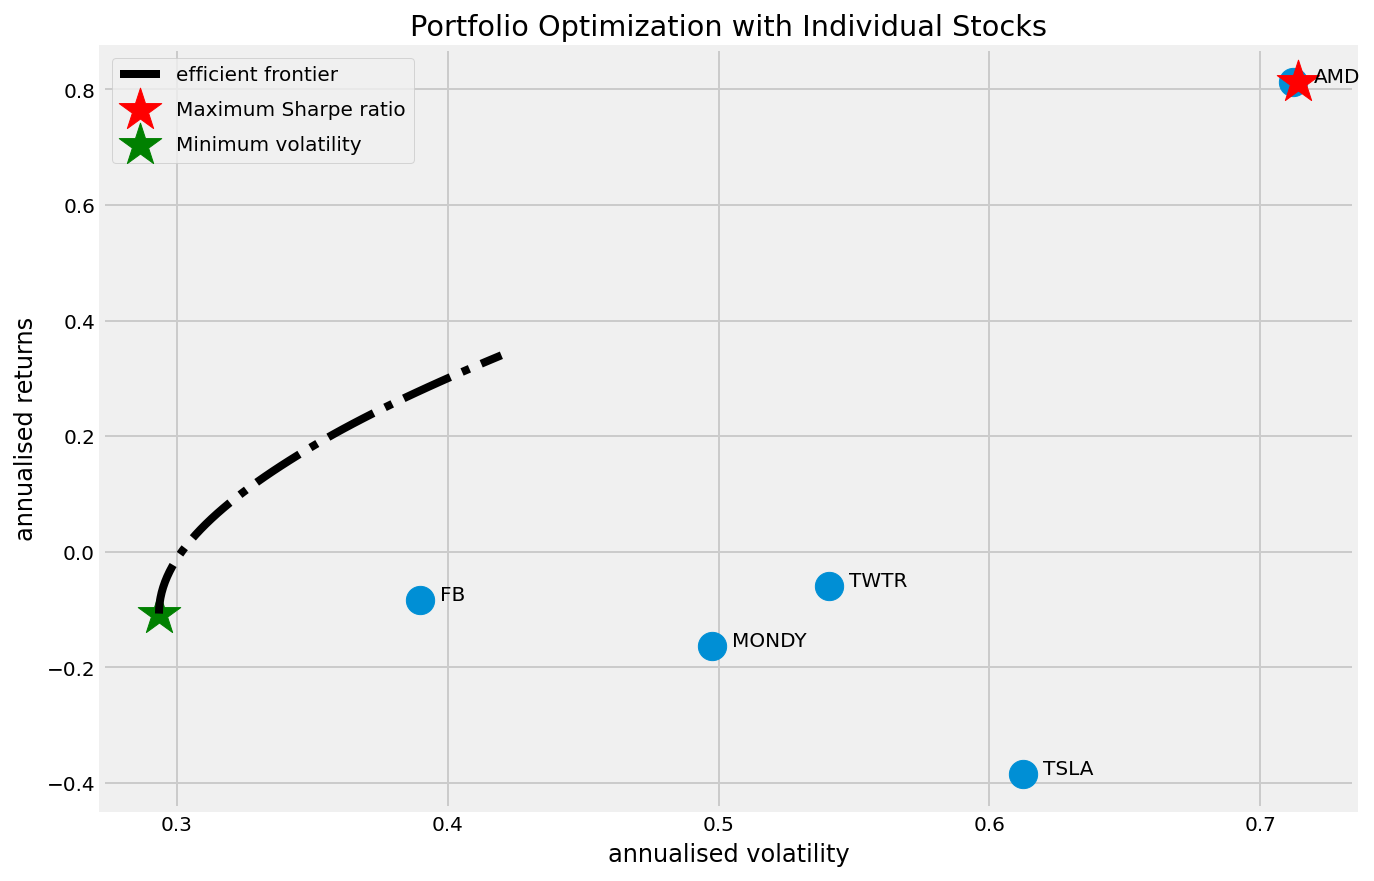

In [18]:
display_ef_with_selected(mean_daily_returns, cov_matrix, risk_free_rate)

As you can see from the above plot, the stock with the least risk is FB at around 0.4. But with portfolio optimisation, we can achieve even lower risk. And if we are willing to take slightly more risk at around the similar level of risk of FB, we can achieve a much higher return of 0.30 with portfolio optimisation.